<a href="https://colab.research.google.com/github/tuphr2234/SignatureForgeryDetection/blob/main/SignatureForgeryDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
#from google.colab import files
#files.upload()

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
 #! kaggle datasets list

In [6]:
!kaggle datasets download -d robinreni/signature-verification-dataset

 99% 593M/601M [00:17<00:00, 40.6MB/s]
100% 601M/601M [00:17<00:00, 36.5MB/s]


In [7]:
! mkdir dataset

In [8]:
! unzip signature-verification-dataset.zip -d dataset

Archive:  signature-verification-dataset.zip
  inflating: dataset/sign_data/sign_data/test/049/01_049.png  
  inflating: dataset/sign_data/sign_data/test/049/02_049.png  
  inflating: dataset/sign_data/sign_data/test/049/03_049.png  
  inflating: dataset/sign_data/sign_data/test/049/04_049.png  
  inflating: dataset/sign_data/sign_data/test/049/05_049.png  
  inflating: dataset/sign_data/sign_data/test/049/06_049.png  
  inflating: dataset/sign_data/sign_data/test/049/07_049.png  
  inflating: dataset/sign_data/sign_data/test/049/08_049.png  
  inflating: dataset/sign_data/sign_data/test/049/09_049.png  
  inflating: dataset/sign_data/sign_data/test/049/10_049.png  
  inflating: dataset/sign_data/sign_data/test/049/11_049.png  
  inflating: dataset/sign_data/sign_data/test/049/12_049.png  
  inflating: dataset/sign_data/sign_data/test/049_forg/01_0114049.PNG  
  inflating: dataset/sign_data/sign_data/test/049_forg/01_0206049.PNG  
  inflating: dataset/sign_data/sign_data/test/049_forg/

In [9]:
import os
train_path = "/content/dataset/sign_data/sign_data/train"

  
  
#print(len(os.listdir(train_path)))

    


In [10]:
fileList=[]
for subdir, dirs, files in os.walk(train_path):
    for file in files:
        fileList.append(file)

In [11]:
#import pathlib
#print(pathlib.Path(fileList[0].resolve())

In [12]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib


data_dir = pathlib.Path('/content/dataset/sign_data/sign_data/train')


In [13]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

1649


In [14]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

Populating the interactive namespace from numpy and matplotlib


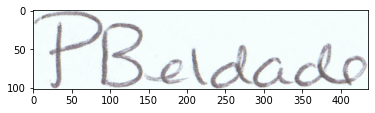

In [15]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(list(data_dir.glob('*/*'))[2])
imgplot = plt.imshow(img)
plt.show()

In [16]:
strListOfImg = list((data_dir.glob('*/*')))

In [17]:
strListOfImg = [str(st) for st in strListOfImg]

In [18]:
strListOfImg.sort()

In [19]:
strListOfImg

['/content/dataset/sign_data/sign_data/train/001/001_01.PNG',
 '/content/dataset/sign_data/sign_data/train/001/001_02.PNG',
 '/content/dataset/sign_data/sign_data/train/001/001_03.PNG',
 '/content/dataset/sign_data/sign_data/train/001/001_04.PNG',
 '/content/dataset/sign_data/sign_data/train/001/001_05.PNG',
 '/content/dataset/sign_data/sign_data/train/001/001_06.PNG',
 '/content/dataset/sign_data/sign_data/train/001/001_07.PNG',
 '/content/dataset/sign_data/sign_data/train/001/001_08.PNG',
 '/content/dataset/sign_data/sign_data/train/001/001_09.PNG',
 '/content/dataset/sign_data/sign_data/train/001/001_10.PNG',
 '/content/dataset/sign_data/sign_data/train/001/001_11.PNG',
 '/content/dataset/sign_data/sign_data/train/001/001_12.PNG',
 '/content/dataset/sign_data/sign_data/train/001/001_13.PNG',
 '/content/dataset/sign_data/sign_data/train/001/001_14.PNG',
 '/content/dataset/sign_data/sign_data/train/001/001_15.PNG',
 '/content/dataset/sign_data/sign_data/train/001/001_16.PNG',
 '/conte

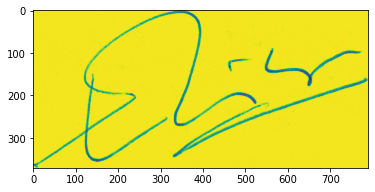

In [20]:
img = mpimg.imread(strListOfImg[2])
imgplot = plt.imshow(rgb2gray(img))
plt.show()

In [21]:
imgTensors = []
for strImg in strListOfImg:
  imgTensors.append(rgb2gray(mpimg.imread(strImg)))

In [22]:
imgTensors[1000].shape

(435, 674)

In [23]:
width=height=0
for i in range(len(imgTensors)):
  height+=imgTensors[i].shape[0]
  width+=imgTensors[i].shape[1]

height = round(height /len(imgTensors))  
width = round(width /len(imgTensors))      

In [ ]:
min=max=imgTensors[0].shape[0] / imgTensors[0].shape[1]
for i in range(len(imgTensors)):
  rasio = imgTensors[i].shape[0] / imgTensors[i].shape[1]
  if rasio > max:
    max = rasio
  if rasio < min:
    min = rasio

  print(f"height/width: min is {min} max is {max}")

In [25]:
#### resize all signature to the same size ((changing the size))   or  padding?
import cv2
for i,img in enumerate(imgTensors):
  imgTensors[i] = cv2.resize(img,(width // 6,height // 6 ))



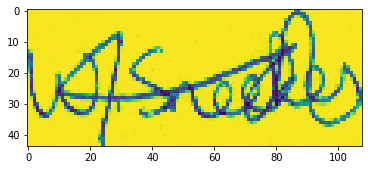

In [26]:
imgplot = plt.imshow(imgTensors[1611])
plt.show()


In [27]:
realSignatures = [] ## list of list of real signatures       ### should both be in the same size!
forgedSignatures = [] ## list of list of forged  signatures

real = []
forged = []
counter = 0


while counter<len(imgTensors):
  
 
  while counter<len(imgTensors) and "forg" not in strListOfImg[counter]:
    real.append(imgTensors[counter])
    counter+=1
    
  
  while counter<len(imgTensors) and "forg" in strListOfImg[counter]:
    forged.append(imgTensors[counter])
    counter+=1

  realSignatures.append(real)
  forgedSignatures.append(forged)


  real = []
  forged= []



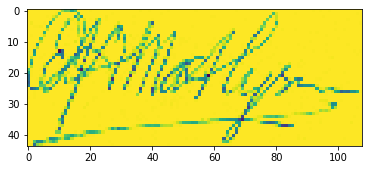

In [28]:
plt.imshow(forgedSignatures[63][4])

In [29]:
def substructImgs(img1,img2):
  return img1 - img2

In [53]:
def avgImgs(img1,img2):
  return (img1+img2)/2

In [30]:
def mixImg(img1,img2):
  arr = np.zeros([height //6,width // 6,2])
  arr[:,:,0] = img1
  arr[:,:,1] = img2
  return arr

In [34]:
def mixAndDiffImg(img1,img2):
  return np.diff(np.diff(mixImg(img1,img2),axis=0),axis=1)

In [59]:
def mixOfsubstructs(img1,img2):
  return mixImg(img1-img2,img2-img1)

In [36]:
#def prepareData()
a = mixAndDiffImg(realSignatures[0][0],realSignatures[0][1])
a.shape

(43, 107, 2)

In [66]:
### total of 64 signatures : 50 for training, 10 for validation, 4 for test

### Prepare data: when using classification stradegy 
### The data is composed of all possible problems: real-real and real-forged, when the model should predict if the second input is a forgery of the first input


X_train =[]
y_train =[]

for i in range(50):
  for j,sig in enumerate(realSignatures[i]):
    
    for k in range(len(realSignatures[i])):
      X_train.append(mixImg(realSignatures[i][j],realSignatures[i][k]))
      y_train.append(1)
    
    for k in range(len(forgedSignatures[i])):
      X_train.append(mixImg(realSignatures[i][j],forgedSignatures[i][k]))
      y_train.append(0) 


X_val =[]
y_val =[]

for i in range(50,64):
  for j,sig in enumerate(realSignatures[i]):
    
    for k in range(j,len(realSignatures[i])):
      X_val.append(mixImg(realSignatures[i][j],realSignatures[i][k]))
      y_val.append(1)
    
    for k in range(j,len(forgedSignatures[i])):
      X_val.append(mixImg(realSignatures[i][j],forgedSignatures[i][k]))
      y_val.append(0) 


X_test =[]
y_test =[]

for i in range(60,64):
  for j,sig in enumerate(realSignatures[i]):
    
    for k in range(j,len(realSignatures[i])):
      X_test.append(mixImg(realSignatures[i][j],realSignatures[i][k]))
      y_test.append(1)
    
    for k in range(j,len(forgedSignatures[i])):
      X_test.append(mixImg(realSignatures[i][j],forgedSignatures[i][k]))
      y_test.append(0)






In [ ]:
## mix
''''
import random as rnd
for i in range(len(X_train)*10):
  rnd1=rnd.randint(0,len(X_train)-1)
  rnd2=rnd.randint(0,len(X_train)-1)

  tempX = X_train[rnd1]
  tempy = y_train[rnd1]
  y_train[rnd1] = y_train[rnd2]
  y_train[rnd1] = y_train[rnd2]
  print("dfdfdfs)hhfhf
  X_train[rnd2] = tempX
  y_train[rnd2] = tempy
'''
####

In [67]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

def model():
  model = Sequential()
  model.add(Conv2D(32, (5, 5), input_shape=(height//6 , width//6 , 2), activation='relu'))
  model.add(MaxPooling2D())
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # Compile model
  return model

In [68]:
model = model()


In [69]:
model.compile(loss='BCE', optimizer='adam', metrics=['accuracy'])


In [70]:
history=model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_val), np.array(y_val)), epochs=15, batch_size=200)


Epoch 1/15
102/102 [==============================] - 4s 31ms/step - loss: 0.7627 - accuracy: 0.5903 - val_loss: 0.6120 - val_accuracy: 0.6672
Epoch 2/15
102/102 [==============================] - 3s 27ms/step - loss: 0.6016 - accuracy: 0.6819 - val_loss: 0.6079 - val_accuracy: 0.6386
Epoch 3/15
102/102 [==============================] - 3s 27ms/step - loss: 0.5306 - accuracy: 0.7436 - val_loss: 0.5323 - val_accuracy: 0.7505
Epoch 4/15
102/102 [==============================] - 3s 27ms/step - loss: 0.4555 - accuracy: 0.7994 - val_loss: 0.5928 - val_accuracy: 0.6923
Epoch 5/15
102/102 [==============================] - 3s 27ms/step - loss: 0.3809 - accuracy: 0.8469 - val_loss: 0.5495 - val_accuracy: 0.7480
Epoch 6/15
102/102 [==============================] - 3s 27ms/step - loss: 0.3300 - accuracy: 0.8701 - val_loss: 0.5442 - val_accuracy: 0.7539
Epoch 7/15
102/102 [==============================] - 3s 27ms/step - loss: 0.2745 - accuracy: 0.9026 - val_loss: 0.5677 - val_accuracy: 0.7470